# Exploratory data analysis <a id='EDA'></a>

The first thing after getting familiar with the problem is to examine the data given to us, look for errors and try to ammend them when possible or exclude them from our pool of data if it's beyond saving.

Next we will be importing a couple of tools that will help us with data exploration:

- Numpy: The mathematical library for python used for nearly every single other library.
- Pandas: A data manupulation tool that highly resembles conceptually R dataframes.
- Matplotlib: A data visualization library. We will be mainly using Panda's API for matplotlib as it's far more untuitive and concise but it is useful to have it as Pandas doesn't include all its functionality.
- Scikit-learn: A marvelous tool for concise tool for machine learning and data manipulation that also contains a lot of functions compatible with pandas dataframes.
- Seaborn: Only to aesthetically modify pandas charts.
- Tqdm: For progress bars in long processes


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost as xgboost
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
#Seaborn graph beautifying
import seaborn as sns
from tqdm import tqdm
sns.set()

import multiprocessing

try:
    cpus = multiprocessing.cpu_count()
except NotImplementedError:
    cpus = 2   # arbitrary default
    
pool = multiprocessing.Pool(processes=cpus)

dateFeatures = ['date', 'checkin', 'checkout']
idFeatures = ['remite_id', 'hotel_id']
valueFeatures = ['adults', 'children']
targetFeature = 'sale'
weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    
import os
print(os.listdir("./Data"))

['clicks.csv']


Process ForkPoolWorker-3:
Process ForkPoolWorker-2:
Process ForkPoolWorker-4:
Process ForkPoolWorker-1:


After importing the data from the csv we use df.info() to get a high level picture of the situation. This will reveal the amount of null values in our data and any errors in the imported datatypes. 

In [2]:
dataset = pd.read_csv("./Data/clicks.csv")
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158161 entries, 0 to 158160
Data columns (total 8 columns):
date         158161 non-null object
remite_id    158161 non-null int64
checkin      158161 non-null object
checkout     158161 non-null object
adults       158161 non-null int64
children     158161 non-null int64
hotel_id     158161 non-null int64
sale         158161 non-null int64
dtypes: int64(5), object(3)
memory usage: 9.7+ MB


### Date correction <a id='DC'></a>
Everything seems ok except the dates that have been imported as objects, we will now correct the type to date so we can use some of pandas functions.

In [3]:
dataset['date'] = dataset['date'].astype('datetime64[ns]')
dataset['checkin'] = dataset['checkin'].astype('datetime64[ns]')
dataset['checkout'] = dataset['checkout'].astype('datetime64[ns]')

Now each column has the correct datatype it is time to separate our data into training and test sets.

We will only be performing our analysis on the training part of our data so the test data remains unseen and we can trully validate if our analysis is generalisable or if we are just overfitting.

In [4]:
dataset_labels = dataset.pop('sale')
X_train, X_test, y_train, y_test = train_test_split(dataset, dataset_labels ,test_size=0.2, random_state = 42)
dataset = X_train.copy() #pd.concat([X_train, y_train])
dataset['sale'] = y_train
dataset['date'] = dataset['date'].astype('datetime64[ns]')
dataset['checkin'] = dataset['checkin'].astype('datetime64[ns]')
dataset['checkout'] = dataset['checkout'].astype('datetime64[ns]')
dataset.head()

,date,remite_id,checkin,checkout,adults,children,hotel_id,sale
145654,2016-04-07,27,2016-04-16,2016-04-17,1,0,207025,0
92803,2016-04-05,130,2016-04-14,2016-04-15,2,0,185998,0
89655,2016-04-04,130,2016-07-01,2016-07-05,2,1,191200,0
146481,2016-04-07,27,2016-04-28,2016-05-01,3,1,1719,0
77875,2016-04-04,27,2016-08-07,2016-08-12,2,0,4265,0


## Target Variable Analysis <a id='TVA'></a>

In [5]:
dataset[targetFeature].unique()

array([0, 1])

No NaN values only 0 or 1 discrete values. With 0 indicating no sale and 1 indicating a sale. Let's have a look at the sales rate and see how sparse it is.

In [6]:
print("Total number of labels: {}".format(dataset.shape[0]))
numZero = dataset[dataset[targetFeature] == 0].shape[0]
numOne = dataset[dataset[targetFeature] == 1].shape[0]
print("Number of 0: {}".format(numZero))
print("Number of 1: {}".format(numOne))
print("Target variable balance: {0}".format((numOne/numZero)*100),"% sales")

Total number of labels: 126528
Number of 0: 124060
Number of 1: 2468
Target variable balance: 1.9893599871030145 % sales


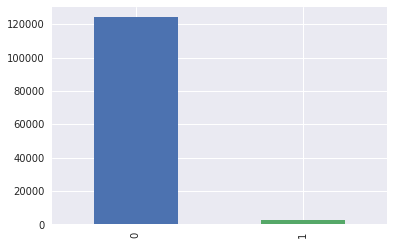

In [7]:
dataset[targetFeature].value_counts().plot(kind='bar')
plt.show()

Sparse number of sales. Most consultations don't end in a purchase. To be expected.

If we had user identifying features we could look at the problem as a sequence of consultations and which ones result in a sale. Some type of clustering might allow us to de-anonimize the data potentially, should be looked into.  

## Independent variable Analysis <a id='IVA'></a>

We will now have a look at the variables that will be used to predict sales.

### Data cleaning <a id='IVADC'></a>

In [8]:
dataset.isnull().sum()

date         0
remite_id    0
checkin      0
checkout     0
adults       0
children     0
hotel_id     0
sale         0
dtype: int64

As we previously saw briefly with df.info() the dataset is surprisingly clean and doesn't require us to interpret any null values which is good.

### Adults and children <a id='IVAAC'></a>

There are no continuous pieces of data in this dataset, however, it can be beneficial to treat some of them like the amount of adults and children depending on the interpretation. 

In other words, is a 0 children booking categorically different to a 2 children booking or can it be considered as part of a continuous scale? 

My first instinct is that the type of customer that has 0 children might be younger and not have kids while a person with 2 might be planning a family vacation and might want to opt for completely other kinds of hotels.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbd380a7208>,
      dtype=object)

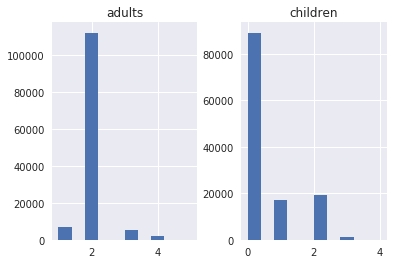

In [9]:
dataset[valueFeatures].hist()

It seems like the most popular way of travelling is in couples and the most popular amount of children to bring with you is unsurprisingly none. 

It is also good to note there are no bookings being done with 0 adults, if this occured it could be a sign that our data is not correct as this is highly irregular as even airbnb will automatically add one adult when the amount of children is non-zero.

We will now explore if there is a correlation between the number of guests (adults and children) and how likely is a sale to happen in a given click.

In [10]:
dataset[valueFeatures+[targetFeature]].corr()

,adults,children,sale
adults,1.000000,0.000545,-0.025734
children,0.000545,1.000000,-0.011733
sale,-0.025734,-0.011733,1.000000


The data shows no particular correlation between the amount of adults and children in a trip and how likely it is to be sold.

### Site interactions in a given day <a id='IVASIIAG'></a>

Interpreting this problem as a time series problem might result in interesting insights. This approach could allow us to see any trends or periodicity in how likely a hotel is to be booked.

In [11]:
dataset.groupby(dataset.date).count()

,remite_id,checkin,checkout,adults,children,hotel_id,sale
date,,,,,,,
2016-04-01,19542,19542,19542,19542,19542,19542,19542
2016-04-02,15236,15236,15236,15236,15236,15236,15236
2016-04-03,18852,18852,18852,18852,18852,18852,18852
2016-04-04,19958,19958,19958,19958,19958,19958,19958
2016-04-05,18755,18755,18755,18755,18755,18755,18755
2016-04-06,17893,17893,17893,17893,17893,17893,17893
2016-04-07,16292,16292,16292,16292,16292,16292,16292


We are only given a small period of 7 days to play around with so it is not possible for us to assess anual, monthly or daily seasonality. This might prove to be enough if we only have to predict features in this period.

We will replace the date with the day name in case new date ranges are later introduced. 

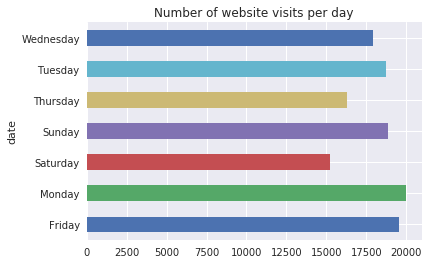

In [12]:
dataset.groupby(dataset.date.dt.day_name()).count().remite_id.plot(kind='barh', title="Number of website visits per day")

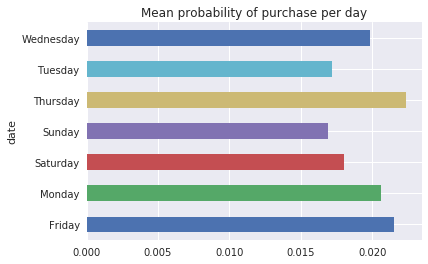

In [13]:
daily_likelyhood = dataset.groupby(dataset.date.dt.day_name()).sale.sum() / dataset.groupby(dataset.date.dt.day_name()).sale.count()
X_train = X_train.join(pd.get_dummies(X_train.date.dt.day_name()))
daily_likelyhood.plot(kind='barh', title="Mean probability of purchase per day")

We can very clearly see a diference in the average sale rate during the week. This piece of information could potentially be a valuable augmented feature.

### Analysis of reservation days <a id='IVAAORD'></a>

It is possible to derive a set of interesting features from the checkin and checkout dates:

- Stay duration
- Distance between reservation and consultation
- Vacations
- Day of the year as a cyclic feature

#### Stay duration <a id='SD'></a>

The distance between the check-in and check-out dates might reveal with what intent was the consultation made. If the booking for example was made for more than 400 days this is a good indication it might be a user mistake.

We will now compute de probability density function of the duration and try to assess if there's a significant different between actual sales and only consultations.

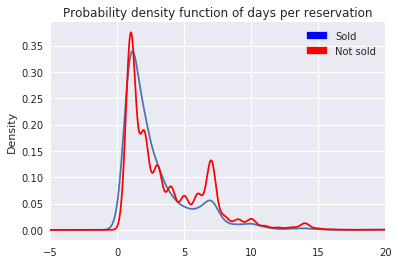

In [14]:
reservation_duration_sold = (dataset[dataset.sale==1].checkout - dataset[dataset.sale==1].checkin).dt.days
reservation_duration_not_sold = (dataset[dataset.sale==0].checkout - dataset[dataset.sale==0].checkin).dt.days

X_train['reservation_duration'] = (dataset.checkout - dataset.checkin).dt.days

fig = plt.figure()
ax = fig.add_subplot(111)
reservation_duration_sold.plot(kind='kde', ax=ax, ind=5000, label='Sold')
reservation_duration_not_sold.plot(kind='kde', ax=ax, color='red', ind=5000, label='Not sold',title='Probability density function of days per reservation')
blue_patch = mpatches.Patch(color='blue', label='Sold')
red_patch = mpatches.Patch(color='red', label='Not sold')
plt.legend(handles=[blue_patch, red_patch])
plt.xlim(-5,20)
ax

As we can see the signature is similar but different enough that we can observe some slight differences. This could possibly be a useful indicator for purchase intention.

Another way to visualize the duration is through a histograms. The next graph contains two histograms stacked on each other, one for actual sales, another for non-sales.

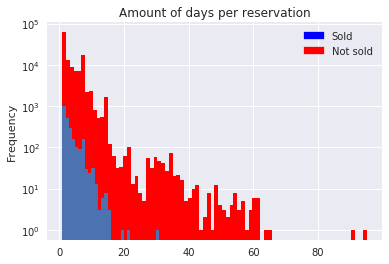

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
reservation_duration_not_sold.plot(kind='hist', bins=80, ax=ax, color='red', log=True, label='Not sold')
reservation_duration_sold.plot(kind='hist', bins=30, ax=ax, log=True, title='Amount of days per reservation')
blue_patch = mpatches.Patch(color='blue', label='Sold')
red_patch = mpatches.Patch(color='red', label='Not sold')
plt.legend(handles=[blue_patch, red_patch])
ax

Here the graph reveals that most purchases are much shorter than consultations. This definitely seems like an interesting metric to take into account for analysis. 

#### Distance between reservation and consultation <a id='DRBAC'></a>

How long in advance a trip is being planned might affect how pressured to buy the customer is. People with not a lot of time might not have the luxury of checking a lot of pages.

To this end we will undertake an analysis similar to the one given to stay duration.

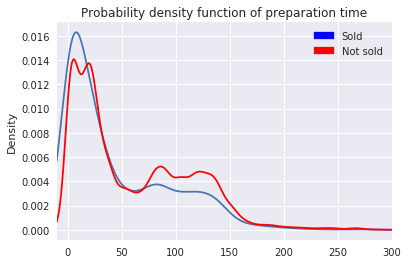

In [16]:
preptime_sold = (dataset[dataset.sale==1].checkin - dataset[dataset.sale==1].date).dt.days
preptime_not_sold = (dataset[dataset.sale==0].checkin - dataset[dataset.sale==0].date).dt.days
X_train['preptime'] = (dataset.checkin - dataset.date).dt.days

fig = plt.figure()
ax = fig.add_subplot(111)
preptime_sold.plot(kind='kde', ax=ax, ind=5000, label='Sold')
preptime_not_sold.plot(kind='kde', ax=ax, color='red', ind=5000, label='Not sold',title='Probability density function of preparation time')
blue_patch = mpatches.Patch(color='blue', label='Sold')
red_patch = mpatches.Patch(color='red', label='Not sold')
plt.legend(handles=[blue_patch, red_patch])
plt.xlim(-10,300)
ax

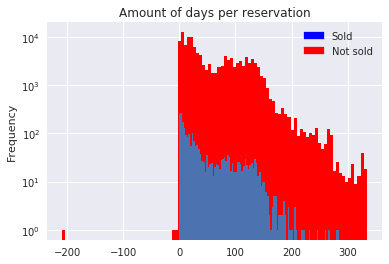

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
preptime_not_sold.plot(kind='hist', bins=100, ax=ax, color='red', log=True, label='Not sold')
preptime_sold.plot(kind='hist', bins=100, ax=ax, log=True, title='Amount of days per reservation')
blue_patch = mpatches.Patch(color='blue', label='Sold')
red_patch = mpatches.Patch(color='red', label='Not sold')
plt.legend(handles=[blue_patch, red_patch])
ax

We find something quite interesting when analysing this data.

Apparently it is possible to consult historical prices for reservations. This doesn't seem correct as most pages will actively block people from trying that. From my knowledge the customer shouldn't be available to then purchase it but just to make sure we will consult once again the data:

In [18]:
dataset[((dataset.checkin - dataset.date).dt.days < 0) & dataset.sale == 1]

,date,remite_id,checkin,checkout,adults,children,hotel_id,sale
68759,2016-04-04,89,2016-04-03,2016-04-04,2,0,80660,1


We find a single late purchase through market portal 89 this is *highly unsual* and should be reported/discussed as it doesn't seem to be normal behaviour even if it is only one day late.

There are another 79 consultations from 5 distinct portals occured in the past and resulted in non-purchase. We can't determine at first glance if we should exclude these rows or if it is a natural part of the behaviour of the application. 

In [19]:
timedelta = (dataset.checkin - dataset.date).dt.days
print("Number of past consultations: {}".format(dataset[((timedelta < 0) & (dataset.sale == 0))].shape[0]))

Number of past consultations: 79


#### Taking holidays into account <a id='THIA'></a>

Taking advantage of holidays to go abroad is a quite frequent occurance because of that it might be possible to augment our data by including some special dates as context.

While the data collected might not be spanish Destinia has its main market in Spain so the holidays we will take local holidays into account.

The next list hast been obtained from https://www.diafestivo.es/ and while it is not a comprehensive list it will serve as a proof-of-concept for the idea.

In [20]:
holidays={'2016-01-01':'New years eve',
          '2016-01-06':'Dia de reyes',
          '2016-05-01':'fiesta del trabajo',
          '2016-08-15':'Asunción de la Virgen',
          '2016-10-12':'Fiesta Nacional de España',
          '2016-11-01':'Dia de todos los santos',
          '2016-11-06':'Dia de la constitucion',
          '2016-11-08':'La inmaculada concepcion',
          '2016-12-25':'Navidad',
          '2017-01-01':'New years eve',
          '2017-01-06':'Dia de reyes',
          '2017-05-01':'fiesta del trabajo',
          '2017-08-15':'Asunción de la Virgen',
          '2017-10-12':'Fiesta Nacional de España',
          '2017-11-01':'Dia de todos los santos',
          '2017-11-06':'Dia de la constitucion',
          '2017-11-08':'La inmaculada concepcion',
          '2017-12-25':'Navidad'
         }

In [21]:
# To do: slow operation could be sped-up with swifter (swiftapply)
def landOnHoliday(row):
    for date in holidays.keys():
        answer = row.checkin < pd.to_datetime(date) < row.checkout
        if answer: return answer
    return False

X_train['includesHoliday'] = X_train.apply(landOnHoliday, axis=1)

In [22]:
percentage = y_train[X_train['includesHoliday']].sum() / y_train[X_train['includesHoliday']].count()
print("Holiday sale percentage: {}".format(percentage))
not_percentage = y_train[~X_train['includesHoliday']].sum() / y_train[~X_train['includesHoliday']].count()
print("Not holiday sale percentage: {}".format(not_percentage))

Holiday sale percentage: 0.017087554816270983
Not holiday sale percentage: 0.019638910895217444


There's a small difference in the mean sale rate but it remains to be seen if this feature will have a big impact on the predictive power of our model.

#### Encoding days of the year as cyclical features <a id='EDOTYACF'></a>

We will now encode our dates as cyclical features as seen in this notebook:
https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning

The rationale behind this particular type of encoding is better ilustrated with an example:

In a typical encoding the 31rst of December would be the day 365 while the first of January would be day 1. This introduces a great distance between two dates that by all means are very similar. A cyclic encoding folds the extremes together better allowing our models to understand the cyclical nature of a year.

This has been shown to increase performance in not only deep learning but also tree based methods.

In [23]:
X_train['checkin_day_sin'] = np.sin(2 * np.pi * X_train['checkin'].dt.dayofyear/365.0)
X_train['checkin_day_cos'] = np.cos(2 * np.pi * X_train['checkin'].dt.dayofyear/365.0)

X_train['checkout_day_sin'] = np.sin(2 * np.pi * X_train['checkout'].dt.dayofyear/365.0)
X_train['checkout_day_cos'] = np.cos(2 * np.pi * X_train['checkout'].dt.dayofyear/365.0)

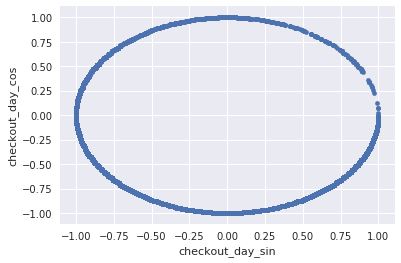

In [24]:
X_train[['checkout_day_sin', 'checkout_day_cos']].plot(
    kind='scatter', x='checkout_day_sin',y='checkout_day_cos')

By combining the cosine and sine components of our day number we can observe how our values now form a circle.

### Study of IDs <a id='SOI'></a>

IDs can be a great source of information. They can be often use to find relationships among data points and ocassionally can allow us to treat data as a sequence of events through proper formatting and models like RNNs.

We are given two sets of ID's we can extract relationships from:

- remite_id: the geographical market of the portal (eg kayak.co.uk, kayak.fr, kayak.de, etc)

- hotel_id: the hotel clicked on by the user

Sadly we have no user IDs but there's still plenty of information to extract. Let's have a look at our range of IDs.

In [25]:
print("Number of unique remite_ids: {}".format(X_train.remite_id.nunique()))
print("Number of unique hotel_ids: {}".format(X_train.hotel_id.nunique()))

Number of unique remite_ids: 5
Number of unique hotel_ids: 9031


As could be expected the number of portals is small and probably quite stable, it could be interesting to use it as a classification variable as it might reveal interesting insights about different nationalities. We will encode them as a one-hot vector to increase compatibility with different ML approaches. If a new portal appears in the test set in will be encoded as a vector of zeros.



In [26]:
remite_id_dummies = pd.get_dummies(X_train.remite_id)
X_train = X_train.join(remite_id_dummies)
remite_id_dummies.head(1)

,27,89,130,316,317
145654,1,0,0,0,0


As for hotels, the number is much larger and, if my experience with the industry doesn't fail me, it is everchanging.

While this is likely not a good candidate for a classification variable there's still plenty of ways we can take advantage of this feature as can be seen in the next section.


### Assesing hotel popularity <a id='AHP'></a>

We will now create an augmented variable derived from how often the hotel is viewed vs bought. This might be interesting as a hotel thumbnail or photo might be eye-catching but the offering itself might be lackluster. This phenomenom is often described as 'clickbait'.

First lets make sure the hotel_ids are not unique for every entry and that we can track several clicks to the same page.

count    9031.000000
mean       14.010409
std        44.658938
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max      1174.000000
dtype: float64


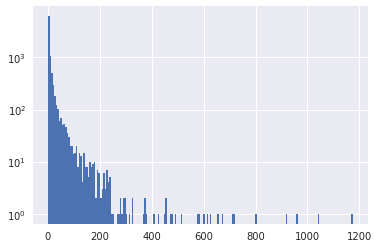

In [27]:
hotels = dataset.groupby("hotel_id")
print(hotels.size().describe())
hotels.size().hist(bins=200, log=True)

Here we have a very skewed distribution of number of visits with a great majority only ever receiving one visit and others receiving over 100 times more. 

This is very important as getting the sales rate of a hotel with sample views n=1 is not only not statiscally significant but might adversely affect our predictive power. We must however be wear of introduccing bias by only sampling highly visited hotels.

In these situations a common technique is to replace the values with the mean. This will not only be used for hotels with very small sample values but also for new hotels for which we have never seen.

We utilize the mean as 0 or 1 would be very extreme values to assign to unknown data.

Mean percentage of sales: 0.018745816563705615


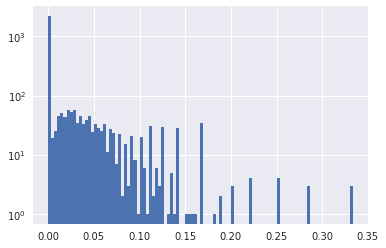

In [28]:
n = 5
filteredHotels = hotels.filter(lambda x: len(x) > n)
filteredHotelIds = filteredHotels.unstack().hotel_id.values
filteredHotels = dataset[dataset.hotel_id.isin(filteredHotelIds)]
hotel_ideality = filteredHotels.groupby("hotel_id").sale.sum() / filteredHotels.groupby("hotel_id").size()
mean_ideality = hotel_ideality.mean()
print("Mean percentage of sales: {}".format(mean_ideality))
hotel_ideality.hist(bins=100,log=True)

Interestingly enough the click percentage seems to be composed of four different sections: 

- A large amount of 0 values
- (ranges 0.01-0.08) A rough and largely skewed normal distribution  
- (ranges 0.09-0.13) A smaller possible normal distribution
- (0.13+) A sparse set of super-performers

This indicates that further feature engineering could be done in the future as there seems to be a set of distinct types of hotels as viewed by this metric.

We will now augment our training dataset with our findings. (Test augmentation will be done in a separate section)

In [29]:
#Improvement: Optimize with defaultDict library to improve escalibility
#depending on implementation of "in" in Series could be O(n*m)

X_train['hotel_ideality'] = X_train.hotel_id.apply(
    lambda x: hotel_ideality[x] if x in hotel_ideality else mean_ideality)

### Dropping non-procesable data <a id='DNPD'></a>

Now we have completed all of our feature engineering it is time to drop the features we won't be able to feed into our models.

In [30]:
X_train = X_train.drop(columns=['date','checkin','checkout','remite_id','hotel_id'])

### Preprocessing the training set <a id='PTTS'></a>

Before we can do any sort of predictions on our data we first have preprocess the test set in a manner coherent with our training set transformations.

The test data hasn't been taken into account in our analysis to enable us to measure how generalisable our transformations are. Overfitting is not limited to algorithms, it can also be done manually if proper steps are not taken to prevent it.

In [31]:
#To do: convert to functions to avoid duplicated code 

X_test = X_test.join(pd.get_dummies(X_test.date.dt.day_name()))
print('Reservation day completed')

X_test['reservation_duration'] = (X_test.checkout - X_test.checkin).dt.days
print('Reservation duration completed')

X_test['preptime'] = (X_test.checkin - X_test.date).dt.days
print('preptime completed')

X_test['includesHoliday'] = X_test.apply(landOnHoliday, axis=1)
print('includesHoliday completed')

X_test['checkin_day_sin'] = np.sin(2 * np.pi * X_test['checkin'].dt.dayofyear/365.0)
X_test['checkin_day_cos'] = np.cos(2 * np.pi * X_test['checkin'].dt.dayofyear/365.0)
print('Checkin cyclical completed')

X_test['checkout_day_sin'] = np.sin(2 * np.pi * X_test['checkout'].dt.dayofyear/365.0)
X_test['checkout_day_cos'] = np.cos(2 * np.pi * X_test['checkout'].dt.dayofyear/365.0)
print('Checkout cyclical completed')

X_test = X_test.join(pd.get_dummies(X_test.remite_id)[remite_id_dummies.columns])

X_test['hotel_ideality'] = X_test.hotel_id.apply(
    lambda x: hotel_ideality[x] if x in hotel_ideality else mean_ideality)
print('Ideality completed')

X_test = X_test.drop(columns=['date','checkin','checkout','remite_id','hotel_id'])
X_test.head(1)

Reservation day completed
Reservation duration completed
preptime completed
includesHoliday completed
Checkin cyclical completed
Checkout cyclical completed
Ideality completed


,adults,children,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,reservation_duration,...,checkin_day_sin,checkin_day_cos,checkout_day_sin,checkout_day_cos,27,89,130,316,317,hotel_ideality
105459,2,0,0,0,0,0,0,1,0,4,...,-0.680773,-0.732494,-0.729558,-0.683919,1,0,0,0,0,0.0


With the transformations done we will now ensure that all our columns match as a small sanity check. 

In [32]:
(X_train.columns == X_test.columns).all()

True

### Dealing with sample imbalance and metric selection <a id='DWSIAMS'></a>

As we saw in our independent variable analysis our samples are extremely imbalanced as sales are fairly sparse (only 2% of every consultation results in a sale)

This essentially makes metrics such as precission quite misleading as, depending on the use case, recall might be more important.

- Precision is defined as true positives divided by the total population.
- Recall is defined as true positives divided by the true positives. 

We will use the f1-score and AUC as they are clearer way to compare our progress. In a real world challenge the type of metric and the balance between precision and recall would be determined by the specific nature of our use case.

Personally I find it easier to guage performance easier with AUC than with F1 scores. AUC-ROC can be summed up with the following rule of thumb:

- 90-1 = excellent (A)
- 80-.90 = good (B)
- 70-.80 = fair (C)
- 60-.70 = poor (D)
- 50-.60 = fail (F)

http://gim.unmc.edu/dxtests/roc3.htm

https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

In [33]:
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score, roc_auc_score
def getScores(y_test, predictions):
    predictions = clf.predict(X_test)
    fscore = f1_score(y_test,predictions)
    prec_score = accuracy_score(y_test,predictions)
    prec_zero_score = accuracy_score(y_test,[0]*len(y_test))
    rec_score = recall_score(y_test,predictions)
    aucscore = roc_auc_score(y_test, predictions)

    print("Baseline Accuracy: Predicting zeros: {}".format(prec_zero_score))
    print("Random-Forest accuracy score: {}".format(prec_score))
    print("Random-Forest recall score: {}".format(rec_score))
    print("Random-Forest f1 score: {}".format(fscore))
    print("Random-Forest ROC AUC score: {}".format(aucscore))
    
    return confusion_matrix(y_test, predictions)

In [34]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

getScores(y_test, predictions)

Baseline Accuracy: Predicting zeros: 0.9803053772958619
Random-Forest accuracy score: 0.9750893054721336
Random-Forest recall score: 0.009630818619582664
Random-Forest f1 score: 0.015000000000000001
Random-Forest ROC AUC score: 0.5020582342049864


array([[30839,   171],
       [  617,     6]])

<a id='BB'></a>
As we can see from our results our accuracy is 0.5% lower than just predicting a non-sale every single time. In exchange our recall is 1.1% percent higher up from 0%.

The score we will be looking at from now on will be AUC-ROC as it is a clearer method of progress. We will also be keeping an eye on our confusion matrix.

#### Simple Undersampling <a id='SU'></a>

Tree-based approaches are said to be fairly resilient against unbalanced datasets but this might be too extreme of a case for random-forest. Before we throw any data away by undersampling it we will take advantage of sklearns class_weight functionality that allows us to tweak class weights in accordance with its frequencies.



In [35]:
clf = RandomForestClassifier(n_estimators=1000, random_state=0, class_weight="balanced",n_jobs=-1)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

getScores(y_test, predictions)

Baseline Accuracy: Predicting zeros: 0.9803053772958619
Random-Forest accuracy score: 0.9462902664938514
Random-Forest recall score: 0.06260032102728733
Random-Forest f1 score: 0.04389420371412493
Random-Forest ROC AUC score: 0.5133220889238339


array([[29895,  1115],
       [  584,    39]])

We immediately see nice bump in recall, f1 scores and ROC AUC while decreasing our accuracy by 4%. The resulting model is better balanced than the previous one but there is still plenty of room for improvement.

We will sample a subset of the data with the hopes of improving performance. At this stage we shouldn't be too concerned about the scores themselves but rather if there's any improvement whatsoever by doing a downsample.

In [36]:
from sklearn.utils import shuffle
def dataset_balance(X_train, y_train, ratio):
    
    training_set = X_train.join(y_train)
    sale_training_set = training_set[training_set.sale == 1]
    non_sale_training_set = training_set[training_set.sale == 0].sample(ratio*len(sale_training_set),replace=True)
    X_balanced_train = shuffle(pd.concat([sale_training_set,non_sale_training_set]))
    print("Number of samples in subset: {}".format(len(X_balanced_train)))
    y_balanced_train = X_balanced_train.pop('sale')
    
    return X_balanced_train, y_balanced_train

In [37]:
X_balanced_train, y_balanced_train = dataset_balance(X_train, y_train, 1)

Number of samples in subset: 4936


Only 4936 samples remain with a perfect 1:1 balance. This is likely not enough for methods like deep learning but we can alter the ratio as we please.

In [38]:
clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
clf.fit(X_balanced_train, y_balanced_train)
predictions = clf.predict(X_test)

getScores(y_test, predictions)

Baseline Accuracy: Predicting zeros: 0.9803053772958619
Random-Forest accuracy score: 0.6521038156355704
Random-Forest recall score: 0.5008025682182986
Random-Forest f1 score: 0.053658956058130536
Random-Forest ROC AUC score: 0.5779730351571983


array([[20316, 10694],
       [  311,   312]])

With 1:1 we get our accuracy to 64% and our recall to 51%.

Our ROC-AUC and F1 scores are increased significantly, we can now see your model is much more balanced than before.

Our key takeaways from this section are:

- Class balacing increases f1-scoring and ROC AUC.
- Methods like tweaking class weights can help increase performance.

#### Advanced oversampling and undersampling (SMOTEENN) <a id='SMOTEENN'></a>

This oversampling and undersampling approach combines SMOTE and Edited Nearest Neighbours to balance samples.

Further reading:

G. Batista, R. C. Prati, M. C. Monard. “A study of the behavior of several methods for balancing machine learning training data,” ACM Sigkdd Explorations Newsletter 6 (1), 20-29, 2004.

In [39]:
from imblearn.combine import SMOTEENN

oversampler = SMOTEENN(random_state=0)
X_SMOTE_train, y_SMOTE_train = oversampler.fit_sample(X_train, y_train)
len(X_SMOTE_train)
X_SMOTE_train = pd.DataFrame(X_SMOTE_train, columns = X_train.columns)
y_SMOTE_train = pd.DataFrame(y_SMOTE_train, columns = [y_train.name])
X_SMOTE_train.head(1)

,adults,children,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,reservation_duration,...,checkin_day_sin,checkin_day_cos,checkout_day_sin,checkout_day_cos,27,89,130,316,317,hotel_ideality
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.963471,-0.267814,0.958718,-0.284359,1.0,0.0,0.0,0.0,0.0,0.0


In [40]:
clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
clf.fit(X_SMOTE_train, y_SMOTE_train)
predictions = clf.predict(X_test)

getScores(y_test, predictions)


/home/skymont/anaconda3/envs/destinia/lib/python3.5/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Baseline Accuracy: Predicting zeros: 0.9803053772958619
Random-Forest accuracy score: 0.9427180476085101
Random-Forest recall score: 0.08667736757624397
Random-Forest f1 score: 0.05625
Random-Forest ROC AUC score: 0.5232967618274642


array([[29767,  1243],
       [  569,    54]])

### Feature Selection and Evaluation <a id='FSAE'></a>

In the previous sections we designed a couple of features from the data given to us. We will now utilize random forest to try to approximate which features are the most important.

In [41]:
clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
clf.fit(X_balanced_train, y_balanced_train)

features = X_train.columns
importances = clf.feature_importances_
indices = np.argsort(importances)

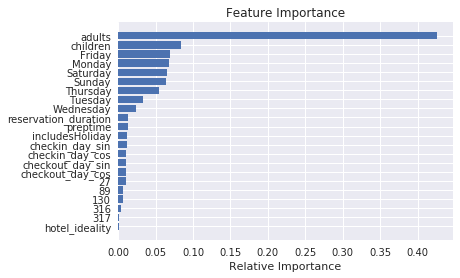

In [42]:
importances = np.array(sorted(importances, reverse=True))
indices = np.argsort(importances)

top20_RF_dataframe_downsampled = [features[i] for i in indices]

plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)),top20_RF_dataframe_downsampled)
plt.xlabel('Relative Importance')
plt.show()

Here we see how some of our engineered features have had a decent impact on our performance. However, they are eclipsed by importance of the feature containing the amount of adults.

A big disappointment was how little predictive power did the hotel ideality end up having. There are a couple possible culprits for this, the main one being a possible high number of hotels not reaching the threshold and defaulting to the average probability. 

## Building a model <a id='BAM'></a>

We will now conduct several trials with different models, there are many to choose from but our study will be limited to the most popular models known for its performance:

- Support Vector Machines
- XGboost
- Artificial Neural Networks


### Support Vector Machines <a id='SVM'></a>



In [43]:
from sklearn.svm import SVC
def SVM_search(kernels, train_data, X_test, y_test):

    for name, X_train, y_train in train_data:
        print("Scores for "+name)
        
        for kernel in kernels:
            svc=SVC(kernel=kernel, gamma='auto')
            svc.fit(X_train,y_train)
            y_pred=svc.predict(X_test)
            print('--'+kernel+' kernel accuracy_score: {0}'.format(roc_auc_score(y_test,y_pred)))
    

def SVM_kernel_search(args):
    kernels, name, X_train, y_train, X_test, y_test = args
    output = "Scores for "+name+":\n"
    for kernel in kernels:
        svc=SVC(kernel=kernel, gamma='auto')
        svc.fit(X_train,y_train)
        y_pred=svc.predict(X_test)
        output += '--'+kernel+' kernel f1_score: {0} \n'.format(roc_auc_score(y_test,y_pred))
    return output
    
            
def SVM_parallel_search(kernels, train_data, X_test, y_test):
    jobs = [(kernels, name, X_train, y_train, X_test, y_test) for name, X_train, y_train in train_data]
    print(pool.map(SVM_kernel_search, jobs))

Based on our results from the class balancing experiments we now benchmark our two best performing datasets with a support vector machines and evaluate de difference in performance between them.

In future experiments it might be desirable to use the original dataset as a control but SVC are notorious for their bad scalability with high number of samples with it's tendency being O(n_samples^2 * n_features). This is made even worse by the fact that traditional SVMs can't be parallelised, the best we can hope for is to distribute processor time between different models. 

In [88]:
kernels=['linear','rbf','poly']
train_data=[#('Original dataset', X_train.head(200), y_train.head(200)),
            ('downsampled dataset', X_balanced_train, y_balanced_train),
            #('SMOTEENN dataset', X_SMOTE_train, y_SMOTE_train),
            #('toy set', X_train.head(200), y_train.head(200))
           ]
SVM_search(kernels, train_data, X_test, y_test)

Scores for downsampled dataset
--linear kernel accuracy_score: 0.5830214247669292
--rbf kernel accuracy_score: 0.5877382794241799
--poly kernel accuracy_score: 0.5772715579244101


Scores for downsampled dataset
- linear kernel f1_score: 0.0625

- rbf kernel f1_score: 0.05115259416727562

- poly kernel f1_score: 0.053603442093940475

### XGboost <a id='XGB'></a>

In [46]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier


def XGboost_search(train_data, X_test, y_test):
    for name, X_train, y_train in train_data:
        model = XGBClassifier()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        predictions = [round(value) for value in y_pred]
        print('--'+name+' f1_score: {0}'.format(roc_auc_score(y_test,y_pred)))
    

In [ ]:
train_data=[('Original dataset', X_train, y_train.values.ravel()),
            ('downsampled dataset', X_balanced_train, y_balanced_train.values.ravel()),
            ('SMOTEENN dataset', X_SMOTE_train, y_SMOTE_train.values.ravel()),
            #('toy set', X_train.head(200), y_train.head(200))
           ]
XGboost_search(train_data, X_test, y_test)

Initial XGBoost results:
- Original dataset 

    - f1_score: 0.0
    - auc_score: 0.5

- downsampled dataset 

    - f1_score: 0.055517711171662126
    - roc_auc_score: 0.5869480305374489

- SMOTEENN dataset 

    - f1_score: 0.06811145510835914
    - dataset roc_auc_score: 0.5708069886843317

Here we see the clear effects of class imbalance. Our model trained on the original dataset has learnt to only predict a non-sale while our more balanced models are showing better f1 and ROC_AUC scores.

## Model tunning <a id='MT'></a>

Model tunning is a complex problem that can be very tedious and computationally expensive process. Determining the right parameters often is more of an art than a science relying mainly on previous experience and a few general guidelines.

To mitigate some of that we will take a page out of Google's book and use some meta-learning techniques. Sadly, we lack the infrastructure to do a wide scale analysis so we will only move forward with our most promissing candidates for SVM and XGboost:

- SVM: Regularly downsampled dataset with Linear Kernel
- XGboost: Trained on SMOTEENN Dataset


### Grid Search for SVMs <a id='GSSVM'></a>

By fixing the dataset and the kernel to be used our problem space is severely reduced to the point where the only main other experimental variable left is C.

The variable C is a regularization parameter. For large values of C the algorithm aims to classify as many samples correctly while at a low C it prioritizes higher margins between the hyperplane and the samples.

In [ ]:
C_range=list(range(20,38))
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics.scorer import make_scorer

acc_score=[]
for c in tqdm(C_range):
    svc = SVC(kernel='linear', C=c)
    scores = cross_val_score(svc, X_balanced_train, y_balanced_train, cv=5, scoring=make_scorer(roc_auc_score))
    acc_score.append(scores.mean())

Text(0,0.5,'Cross-Validated Accuracy')

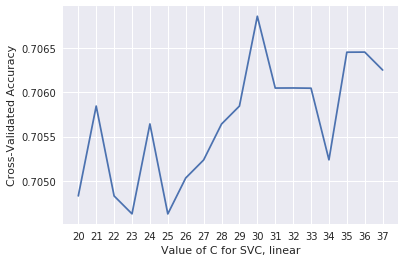

In [50]:
plt.plot(C_range,acc_score)
plt.xticks(np.arange(20,38,1))
plt.xlabel('Value of C for SVC, linear')
plt.ylabel('Cross-Validated Accuracy')

In [56]:
svc=SVC(kernel='linear', C=30)
svc.fit(X_balanced_train,y_balanced_train)
y_pred=svc.predict(X_test)
print('--linear kernel C=30 ROC AUC: {0} \n'.format(roc_auc_score(y_test,y_pred)))

--linear kernel C=30 ROC AUC: 0.5720342115084297 



We can see that with our relatively short and very coarse search for the optimal value of C we weren't able to find a better performance than in our first run with our balanced dataset. Not to be discouraged, a thorough tuning would at least yield the results seen in our previous attempt and often leads to increased performance.

We can see from our steep performance reduction in the test dataset that our model seems to be overfitting our balanced dataset and not generalising successfully to our test set.

The next steps down this route would extend the search of C further until we saw a decrease in performance and then reduce the step at which C increases, refining the optimization. 

### Bayesian optimization and XGBoost <a id='BOXGB'></a>

XGBoost models have a great amount of parameters to optimize. This makes the problem space insurmountable for brute-force approaches like grid search. This bayesian optimization library treats what it is optimizing as a black-box and hence has a great range of applications

For a detailed under the hood explanation on how this optimization process works please head to: https://github.com/fmfn/BayesianOptimization

In [ ]:
from bayes_opt import BayesianOptimization
import warnings
warnings.filterwarnings(action='once')
xgtrain = xgb.DMatrix(X_balanced_train, label=y_balanced_train)

def xg_f1(y,t):
    t = t.get_label()
    y_bin = [round(value) for value in y]
    return 'f1',f1_score(t,y_bin)

def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma,
                 alpha,
                 n_estimators):

    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
    params['max_depth'] = int(max_depth)
    params['subsample'] = max(min(subsample, 1), 0)
    params['gamma'] = max(gamma, 0)
    params['alpha'] = max(alpha, 0)
    params['n_estimators'] = int(n_estimators)


    cv_result = xgb.cv(params, xgtrain, num_boost_round=100, nfold=5,
             seed=random_state,
             callbacks=[xgb.callback.early_stop(5)], feval=xg_f1)
    return cv_result['test-f1-mean'].values[-1]


random_state = 17
num_iter = 50
init_points = 25
params = {
    'eta': 0.1,
    'silent': 1,
    'nthread':4,
    'eval_metric': 'error',
    'verbose_eval': False,
    'seed': 17,
    'learning_rate':0.1
}

xgbBO = BayesianOptimization(xgb_evaluate, {'min_child_weight': (1, 20),
                                            'colsample_bytree': (0.1, 1),
                                            'max_depth': (3, 50),
                                            'subsample': (0.5, 1),
                                            'gamma': (0, 15),
                                            'alpha': (0, 15),
                                            'n_estimators':(200, 5000)
                                            })

xgbBO.maximize(init_points=init_points, n_iter=num_iter)

After 75 steps we arrive at a combination of parameters that achieves a score of 0.70 in our SMOTEENN dataset. We will now validate those parameters on our test dataset to see what improvement is there, if any.

In [ ]:
print(xgbBO.res['max'])
min_child_weight = int(xgbBO.res['max']['max_params']['min_child_weight'])
colsample_bytree = int(xgbBO.res['max']['max_params']['colsample_bytree'])
max_depth = int(xgbBO.res['max']['max_params']['max_depth'])
subsample = float(xgbBO.res['max']['max_params']['subsample'])
gamma = float(xgbBO.res['max']['max_params']['gamma'])
alpha = float(xgbBO.res['max']['max_params']['alpha'])
n_estimators = int(xgbBO.res['max']['max_params']['n_estimators'])

model = XGBClassifier(n_estimators=n_estimators, 
                      alpha=alpha, 
                      gamma=gamma, 
                      subsample=subsample, 
                      max_depth=max_depth,
                      colsample_bytree=1,
                     )

model.fit(X_SMOTE_train, y_SMOTE_train.values.ravel(),eval_metric='auc')
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
print('--BayesOpt XGboost'+' ROC_AUC_score: {0}'.format(roc_auc_score(y_test,y_pred)))

Once again our score is significantly reduced in the real test_set indicating a fair amount of overfitting in the model. 

### Artificial Neural Networks <a id='BOXGB'></a>

ANNs can be very powerful predictive models with a very wide range of applications. Binary classification is relatively straight forward to do but this approach has a few pitfalls:

- Tendency to overfit
- Susceptible to class imbalance
- High computational cost for larger models
- Limitations on deployment (Edge-computing)

For a first look at the performance of ANNs we will use the Keras library. Keras  is an api on top of Tensorflow that trades some fine-control of models with usability and development-speed. Alternatively we could use "Tensorflow.Keras" a keras-like API included in Tensorflow for a similar effect.

The following code is just a multi-layer preceptron similar to the one that can be found in Sci-kit learn.

In [ ]:
num_classes = 2

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

model = Sequential()
model.add(Dense(len(X_train.columns), activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes,activation='softmax'))

In [ ]:
import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from keras.utils import to_categorical
from keras import backend as K

batch_size = 5000
epochs = 15

def keras_f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * ((precision * recall) / (precision + recall))
    return f1_score

opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss='categorical_crossentropy',
              optimizer=opt, metrics=[keras_f1_score])

history = model.fit(
    X_SMOTE_train.values, to_categorical(y_SMOTE_train.values),
    validation_data=(X_test, to_categorical(y_test)),
    batch_size=batch_size,epochs=epochs,
    verbose=1)

predictions = model.predict(X_test).argmax(axis=1)
roc_auc_score(y_test, predictions)

As expected performance is relatively poor in comparison to the other approaches we've covered. 

Overfitting poses a big challenge our situation. Using the original unbalanced dataset results in a 0.03 f1-score and using the balanced downsampled set results in extremely fast overfitting as well as poor performance. 

Even the best performing dataset (SMOTEENN) encounters overfitting issues fairly quickly. 

## Further Work <a id='FW'></a>

Be it due to time constraints or lack of features in the dataset there are a number of points that weren't able to be included but I would like to mention as it could provide value in the future.

### Further feature engineering. <a id='FFE'></a>

I believe big source of uncertainty comes from the lack user_ids in the data, while it is not always possible to collect them that doesn't mean it couldn't be found out.

It is possible that with the right kind of clustering we can associate consultations together essentially de-anonimizing the data or at the very list determining if there are several types of consultations with the features given to us. This if combined with timestamps on the consultations would possibly allow us to treat a user's consultation as a sequence of events leading to an outcome.

On the subject of further data collection, it is safe to say that the hotel's characteristics (Rooms, busy periods, location, price, discounts) would probably allow us to have better insights into what determines a sale or not.

Due to time constraints other measures of feature importance have not been tested. A popular approach we haven't seen is PCA decompsition. It would not only allow us to potentially reduce the amount of features we feed into the model but we would be also be able to see which features account for most of the variance. 

### Different models <a id='DM'></a>

The naive bayes family of algorithms are known to be able to tackle edge-cases very effectively when compared to the models we have covered here. It is possible that this approach would have yielded better results with adequate feature engineering.

One possible way of increasing the performance of the ANN approach would be to implement an asymmetric loss function that penalizes missed sales (False Negatives) more than it penalizes (False positives) while retaining as much of the data as possible. This could potentially raise the accuracy level while encouraging the model to predict sales.

Further experimentation with ANN tuning would also be a possible next step, there are plenty of different compositions, activation functions and optimizers that could be tested and would likely result in a performance bump.

### Use case definition <a id='UCD'></a>

Without a proper definition of the use case it can be challenging to gauge success of an algorithm. As it stands, our proposed models happily compromise on accuracy with the hopes of actually predicting a sale. This could potentially be catastrophic if the use case was the automated reservation of a hotel. In that case a false positives would be something penalize heavily. 

### Conclusion <a id='CTY'></a>

While we only manage present a poor predictor of sales (Just under 0.60 ROC AUC) in this document a lot groundwork has been laid to be built upon. 

I'd like to thank Destinia for providing me with the opportunity of facing this challenge. I look forward to hearing feedback on this analysis, be it positive or negative. 